In [2]:
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [6]:
file_path = "../Data/all_processed_HiC/K_all_hic_cont.csv.gz"
df = pd.read_csv(file_path)
df.head()

,chr,ibp,jbp,fq,fdr,rawc
0,chr1,69740000,69780000,0.780465,0.0,29.353172
1,chr1,69740000,69790000,0.370194,0.0,22.741314
2,chr1,69740000,69950000,0.068101,0.0,12.943521
3,chr1,69740000,71210000,0.035838,0.0,10.222382
4,chr1,69745000,69800000,0.531329,0.0,25.584558


In [3]:
df_refined_GM = pd.read_csv("../Data/all_processed_HiC/GM_all_hic_cont.csv.gz")

# get the average value of 'fq' and 'fdr' for each group
df_refined_GM = df_refined_GM.groupby(["chr", "ibp", "jbp"], as_index=False).agg(
    {"fq": "mean", "fdr": "mean", "rawc": "first"}
)

In [5]:
df_refined_GM.head()

,chr,ibp,jbp,fq,fdr,rawc
0,chr1,3320000,3320000,1.000000,1.000000,156.021600
1,chr1,3320000,3325000,1.000000,1.000000,59.187775
2,chr1,3320000,3330000,1.000000,1.000000,39.219370
3,chr1,3320000,3335000,0.998299,0.981670,24.210155
4,chr1,3320000,3340000,0.809792,0.855084,20.779170


**Gene Data**


In [2]:
file_path = "../Data/ncbi_dataset.tsv"
gene_df = pd.read_csv(file_path, sep="\t")
gene_df = gene_df[["Gene ID", "Name", "Symbol", "Chromosome", "Begin", "End"]]
gene_df

,Gene ID,Name,Symbol,Chromosome,Begin,End
0,100287102,DEAD/H-box helicase 11 like 1 (pseudogene),DDX11L1,1,11874,14409
1,653635,"WASP family homolog 7, pseudogene",WASH7P,1,14362,29370
2,102466751,microRNA 6859-1,MIR6859-1,1,17369,17436
3,107985730,MIR1302-2 host gene,MIR1302-2HG,1,29774,35418
4,100302278,microRNA 1302-2,MIR1302-2,1,30366,30503
...,...,...,...,...,...,...
68320,100289087,testis specific protein Y-linked 10,TSPY10,Y,752540,755334
68321,642631,"testis specific protein Y-linked 15, pseudogene",TSPY15P,Y,772716,775527
68322,64593,RNA binding motif protein Y-linked family 3 me...,RBMY3AP,Y,835375,839807
68323,100874288,"testis specific protein Y-linked 25, pseudogene",TSPY25P,Y,848837,851006


In [2]:
data_dir = "../Data/all_processed_HiC"
out_put_dir = "../Data/refined_processed_HiC"


files = [f for f in os.listdir(data_dir) if f.endswith(".csv.gz")]

for file in files:
    # cell line name
    cell_line = file.split("_")[0]

    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)

    # get the average value of 'fq' and 'fdr' for each group
    df = df.groupby(["chr", "ibp", "jbp"], as_index=False).agg(
        {"fq": "mean", "fdr": "mean", "rawc": "first"}
    )

    df["cell_line"] = cell_line

    # save the processed HiC file
    processed_file_path = os.path.join(out_put_dir, f"{cell_line}_processed.csv.gz")
    df.to_csv(processed_file_path, index=False, compression="gzip")
    print(f"Processed file saved to {processed_file_path}")

Processed file saved to ../Data/refined_processed_HiC/K_processed.csv.gz
Processed file saved to ../Data/refined_processed_HiC/IMR_processed.csv.gz
Processed file saved to ../Data/refined_processed_HiC/GM_processed.csv.gz


In [5]:
file_path = "../Data/refined_processed_HiC/IMR_processed.csv.gz"
IMR_df = pd.read_csv(file_path)
print(IMR_df.tail())

            chr        ibp        jbp   fq  fdr        rawc cell_line
121150427  chrX  154055000  154060000  1.0  1.0   98.492010       IMR
121150428  chrX  154055000  154065000  1.0  1.0   59.830734       IMR
121150429  chrX  154060000  154060000  1.0  1.0  187.421430       IMR
121150430  chrX  154060000  154065000  1.0  1.0  102.419624       IMR
121150431  chrX  154065000  154065000  1.0  1.0  198.546620       IMR


**Get example data from the refined csv.gz, get 3 chrs from each file, these chrs exist in each file**

In [3]:
def process_and_sample_data(input_folder, output_folder, sample_count=2):
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Collect the intersection of 'chr' values across all files
    common_chromosomes = None

    # First pass: Identify common 'chr' values
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv.gz"):
            input_path = os.path.join(input_folder, filename)

            # Load the compressed CSV file
            df = pd.read_csv(input_path, compression="gzip")

            # Check if 'chr' column exists
            if "chr" not in df.columns:
                print(f"'chr' column not found in {filename}. Skipping this file.")
                continue

            # Update the set of common chromosomes
            file_chromosomes = set(df["chr"].unique())
            if common_chromosomes is None:
                common_chromosomes = file_chromosomes
            else:
                common_chromosomes &= file_chromosomes

    # Check if we have enough common chromosomes
    if common_chromosomes is None or len(common_chromosomes) < sample_count:
        print(f"Not enough common chromosomes across all files. Process aborted.")
        return

    # Randomly select the required number of common chromosomes
    sampled_chromosomes = random.sample(common_chromosomes, sample_count)
    print(f"Sampled chromosomes: {sampled_chromosomes}")

    # Second pass: Process each file with the sampled chromosomes
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv.gz"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Load the compressed CSV file
            df = pd.read_csv(input_path, compression="gzip")

            # Filter the dataframe to include only the selected chromosomes
            sampled_data = df[df["chr"].isin(sampled_chromosomes)]

            # Save the sampled data to the output file in gzip format
            sampled_data.to_csv(output_path, index=False, compression="gzip")
            print(f"Processed and saved {filename} with {sample_count} common 'chr' groups to {output_folder}")


# Define your input and output folders
input_folder = "../Data/refined_processed_HiC"
output_folder = "../Example_Data/refined_processed_HiC"

# Run the function
process_and_sample_data(input_folder, output_folder)


/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_75848/2276497908.py:34: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_chromosomes = random.sample(common_chromosomes, sample_count)


Sampled chromosomes: ['chr17', 'chr12']
Processed and saved IMR_processed.csv.gz with 2 common 'chr' groups to ../Example_Data/refined_processed_HiC
Processed and saved GM_processed.csv.gz with 2 common 'chr' groups to ../Example_Data/refined_processed_HiC
Processed and saved K_processed.csv.gz with 2 common 'chr' groups to ../Example_Data/refined_processed_HiC


**Find each cell line chromosome's range**


In [14]:
import os
import pandas as pd
from pathos.multiprocessing import ProcessingPool as Pool

def process_file(args):
    input_folder, filename, output_folder = args
    if not filename.endswith(".csv.gz"):
        return

    cell_line = filename.split("_")[0]
    file_path = os.path.join(input_folder, filename)
    df = pd.read_csv(file_path, compression="gzip")

    df["ibp_end"] = df["ibp"] + 5000
    df["jbp_end"] = df["jbp"] + 5000

    # batch processing
    ibp_ranges = df[["chr", "ibp", "ibp_end"]].rename(columns={"ibp": "start_value", "ibp_end": "end_value"})
    jbp_ranges = df[["chr", "jbp", "jbp_end"]].rename(columns={"jbp": "start_value", "jbp_end": "end_value"})
    ranges = pd.concat([ibp_ranges, jbp_ranges])
    ranges["cell_line"] = cell_line

    ranges = ranges.drop_duplicates().sort_values(by=["chr", "start_value", "end_value"])

    # merge adjacent ranges
    merged_results = []
    for chr_id, group in ranges.groupby("chr"):
        group = group.sort_values(by="start_value").to_dict(orient="records")
        merged = [group[0]]

        for entry in group[1:]:
            last = merged[-1]
            if last["end_value"] >= entry["start_value"]:
                last["end_value"] = max(last["end_value"], entry["end_value"])
            else:
                merged.append(entry)

        for entry in merged:
            merged_results.append({
                "cell_line": cell_line,
                "chrID": chr_id,
                "start_value": entry["start_value"],
                "end_value": entry["end_value"],
            })

    result_df = pd.DataFrame(merged_results, columns=["cell_line", "chrID", "start_value", "end_value"])

    # save
    output_filename = f"{cell_line}_ranges.csv.gz"
    output_path = os.path.join(output_folder, output_filename)
    result_df.to_csv(output_path, index=False, compression="gzip")
    print(f"Processed and saved: {output_filename}")

def main(input_folder, output_folder, num_workers=4):
    files = [(input_folder, filename, output_folder) for filename in os.listdir(input_folder) if filename.endswith(".csv.gz")]

    # process files in parallel
    with Pool(num_workers) as pool:
        pool.map(process_file, files)

input_folder = "./refined_processed_HiC"
output_folder = "./seqs"


main(input_folder, output_folder)

**Check valid range**

In [3]:
file_path = "../Data/valid_regions/Cyt49_valid_regions.csv.gz"
Cyt49v2_valid_df = pd.read_csv(file_path, compression="gzip")
filtered_valid_df = Cyt49v2_valid_df[
    (Cyt49v2_valid_df['end_value'] <= 12945000) &
    (Cyt49v2_valid_df['chrID'] == 'chr1')
]
filtered_valid_df


,cell_line,chrID,start_value,end_value
0,Cyt49,chr1,1000000,2600000
1,Cyt49,chr1,2775000,6650000
2,Cyt49,chr1,6400000,9800000
3,Cyt49,chr1,9550000,11200000
4,Cyt49,chr1,10950000,12300000
5,Cyt49,chr1,12050000,12945000


In [5]:
file_path = "../Data/seqs/Cyt49_ranges.csv.gz"
Cyt49v2_df = pd.read_csv(file_path, compression="gzip")
filtered_df = Cyt49v2_df[
    (Cyt49v2_df['end_value'] <= 12945000) &
    (Cyt49v2_df['chrID'] == 'chr1')
]
filtered_df

,cell_line,chrID,start_value,end_value
0,Cyt49,chr1,1000000,1075000
1,Cyt49,chr1,1085000,1710000
2,Cyt49,chr1,1720000,1745000
3,Cyt49,chr1,1755000,2270000
4,Cyt49,chr1,2280000,2600000
5,Cyt49,chr1,2780000,12905000
6,Cyt49,chr1,12915000,12940000


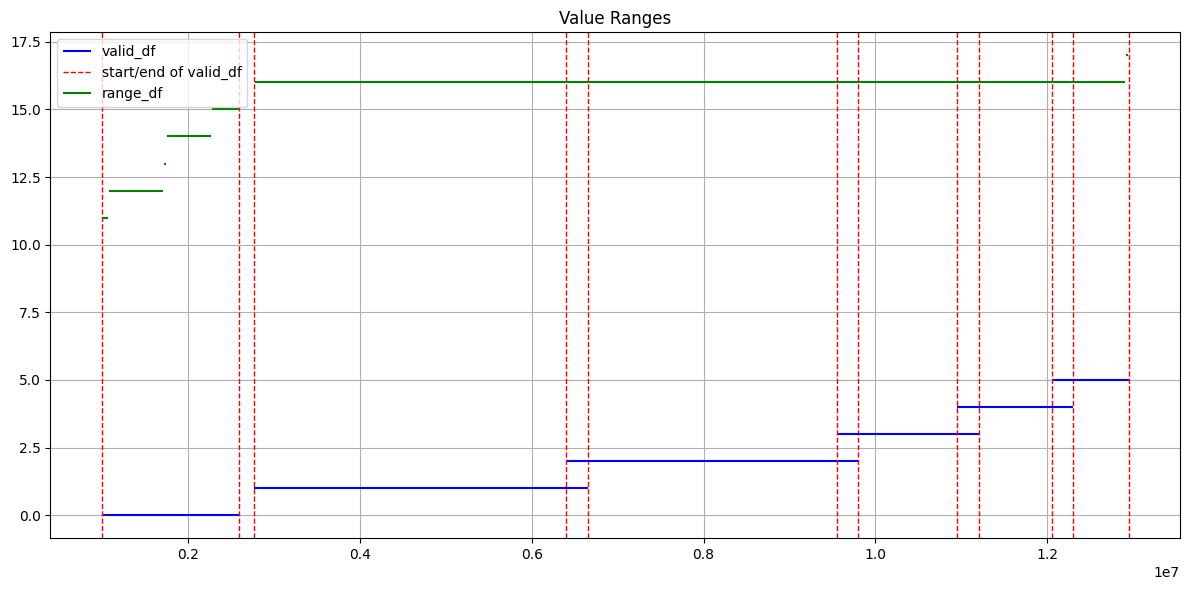

In [6]:
valid_df = filtered_valid_df.reset_index(drop=True)
range_df = filtered_df.reset_index(drop=True)

plt.figure(figsize=(12, 6))

for i, row in valid_df.iterrows():
    plt.hlines(y=i, xmin=row['start_value'], xmax=row['end_value'], color='blue', label='valid_df' if i==0 else "")
    
    plt.axvline(x=row['start_value'], color='red', linestyle='--', linewidth=1, label='start/end of valid_df' if i==0 else "")
    plt.axvline(x=row['end_value'], color='red', linestyle='--', linewidth=1)

offset = len(valid_df) + 5
for i, row in range_df.iterrows():
    plt.hlines(y=i + offset, xmin=row['start_value'], xmax=row['end_value'], color='green', label='range_df' if i==0 else "")

plt.title('Value Ranges')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [49]:
valid_df = filtered_valid_df.reset_index(drop=True)
range_df = filtered_df.reset_index(drop=True)

for idx, row in range_df.iterrows():
    r_start = row['start_value']
    r_end = row['end_value']
    
    overlapping_ranges = []
    
    for _, valid_row in valid_df.iterrows():
        v_start = valid_row['start_value']
        v_end = valid_row['end_value']
        
        if r_start <= v_end and r_end >= v_start:
            overlapping_ranges.append((v_start, v_end))
    
    if overlapping_ranges:
        print(f"Range {r_start}-{r_end} overlaps with valid ranges: {overlapping_ranges}")
    else:
        print(f"Range {r_start}-{r_end} does NOT overlap with any valid range.")


Range 1000000-1075000 overlaps with valid ranges: [(1000000, 2600000)]
Range 1085000-1710000 overlaps with valid ranges: [(1000000, 2600000)]
Range 1720000-1745000 overlaps with valid ranges: [(1000000, 2600000)]
Range 1755000-2270000 overlaps with valid ranges: [(1000000, 2600000)]
Range 2280000-2600000 overlaps with valid ranges: [(1000000, 2600000)]
Range 2780000-12905000 overlaps with valid ranges: [(2775000, 6650000), (6400000, 9800000), (9550000, 11200000), (10950000, 12300000), (12050000, 12945000)]
Range 12915000-12940000 overlaps with valid ranges: [(12050000, 12945000)]


In [6]:
file_path = "../Example_Data/seqs/K_ranges.csv.gz"
IMR_df = pd.read_csv(file_path)

print(f"Total rows: {len(IMR_df)}")
print(IMR_df)

equal_values_df = IMR_df[IMR_df["start_value"] == IMR_df["end_value"]]

print(f"Rows where start_value == end_value: {len(equal_values_df)}")

if len(equal_values_df) > 0:
    print("Rows where start_value == end_value:")
    print(equal_values_df)
else:
    print("No rows where start_value == end_value found.")


Total rows: 44
   cell_line  chrID  start_value  end_value
0          K  chr12       315000    8410000
1          K  chr12      8415000    8425000
2          K  chr12      8435000    9515000
3          K  chr12      9530000    9555000
4          K  chr12      9565000   11360000
5          K  chr12     11370000   11375000
6          K  chr12     11390000   34510000
7          K  chr12     39180000  132600000
8          K  chr17       605000   12450000
9          K  chr17     12455000   18460000
10         K  chr17     18465000   19155000
11         K  chr17     19160000   19165000
12         K  chr17     19180000   19190000
13         K  chr17     19205000   19215000
14         K  chr17     19220000   21800000
15         K  chr17     21810000   21905000
16         K  chr17     21920000   21925000
17         K  chr17     21930000   21955000
18         K  chr17     21965000   21995000
19         K  chr17     22040000   22520000
20         K  chr17     27085000   36380000
21         K  chr

In [19]:
data = np.load('K_chr1_2450000_2705000.npz')
print(data.files)
print(data["shape"])

matrix = sp.csr_matrix((data["data"], data["indices"], data["indptr"]), shape=data["shape"])
dense_matrix = matrix.toarray()
df = pd.DataFrame(dense_matrix)

df

['indices', 'indptr', 'format', 'shape', 'data']
[5000 1275]


,0,1,2,3,4,5,6,7,8,9,...,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274
0,34.292301,57.094101,69.618103,102.112999,131.024002,163.908005,172.261993,184.927002,188.311996,201.160995,...,34.292301,43.448601,71.340599,91.240402,34.292301,48.499500,73.156403,34.292301,47.875801,34.292301
1,34.292301,59.151001,79.738899,99.418098,120.431000,129.393005,160.494995,193.716995,183.884995,191.434006,...,34.292301,39.137001,53.961498,84.333298,34.292301,52.929001,80.760300,34.292301,54.018501,34.292301
2,34.292301,53.948502,79.840897,100.455002,112.235001,122.777000,117.584999,96.740097,130.162003,132.561996,...,34.292301,39.137001,53.961498,84.333298,34.292301,52.929001,80.760300,34.292301,54.018501,34.292301
3,34.292301,57.668800,82.238403,97.935997,71.113899,56.880901,81.739998,88.008499,73.631500,80.651703,...,34.292301,42.113499,58.326000,76.532700,34.292301,39.488098,70.060303,34.292301,54.147202,34.292301
4,34.292301,34.299198,49.649799,81.892502,74.327797,62.299900,70.961700,45.382401,75.189697,68.449303,...,34.292301,65.080299,82.542000,100.058998,34.292301,56.971298,79.457603,34.292301,66.072601,34.292301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,34.292301,58.924900,92.550903,105.151001,93.401901,86.114098,77.081100,107.155998,140.664001,167.643997,...,34.292301,47.960999,38.798801,53.976101,34.292301,49.935001,66.638100,34.292301,61.394699,34.292301
4996,34.292301,59.440800,90.787498,107.887001,120.329002,118.429001,112.918999,80.866402,78.485603,111.954002,...,34.292301,50.868401,50.196499,59.550999,34.292301,46.781300,71.538803,34.292301,54.297501,34.292301
4997,34.292301,58.277401,82.855598,100.616997,93.360497,66.254799,57.604500,68.125000,76.384499,57.893002,...,34.292301,36.821899,69.186401,57.680599,34.292301,64.358200,70.636497,34.292301,38.100300,34.292301
4998,34.292301,59.194401,63.932499,96.217903,115.903999,118.449997,90.779503,84.812401,64.729401,44.770500,...,34.292301,59.846401,66.375298,80.883499,34.292301,35.742500,47.312801,34.292301,34.823700,34.292301
